In [6]:
# ==========================================
# 0. IMPORTS
# ==========================================

#probando si esto se commitea Segunda prueba desde otro pc
#Nota de intiti: si van a trabajar desde un entorno local (Visual), 
# asegúrense de tener instaladas las librerías necesarias.
#tutorial: ctrl + ñ para abrir el terminal y luego pegar los siguientes comandos:
#comando para instalar torch: pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 -> En caso que quieran usar GPU.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import concurrent.futures # LIBRERÍA MAGICA PARA PARALELISMO
import multiprocessing
import numpy as np
import os
import glob
import math
from tqdm import tqdm
import os
import requests 
import gc # Garbage Collector para gestión de memoria

In [ ]:
#prueba de intiti
#prueba inti 2
#prueba inti 3

In [2]:
# ==========================================
# 1. CONFIGURACIÓN, GPU Y DESCARGA DE DATOS
# ==========================================


# --- A. CONFIGURACIÓN DEL HARDWARE (DEVICE) ---
# Esto es vital para que el Bloque de entrenamiento sepa qué usar
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"✅ GPU DETECTADA: {torch.cuda.get_device_name(0)}")
    print(f"   (Memoria disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB)")
else:
    DEVICE = torch.device("cpu")
    print("⚠️ GPU NO DETECTADA: Entrenando en CPU (será lento).")

# --- B. CONFIGURACIÓN DEL REPOSITORIO ---
REPO_USER = "felipe-astudillo-s"
REPO_NAME = "TransformerTSP"
BRANCH = "main" # ⚠️ IMPORTANTE: Si tus datos no están en 'main', cambia esto por el nombre de tu rama o commit.

REPO_FOLDERS = {
    "EASY":   "Data/Easy",
    "MEDIUM": "Data/Medium",
    "HARD":   "Data/Hard"
}

BASE_LOCAL_DIR = os.path.join(os.getcwd(), "data_repo")

def download_folder_from_github(user, repo, repo_folder_path, local_output_dir, branch="main"):
    """Descarga todos los .npz de una carpeta de GitHub usando la API."""
    api_url = f"https://api.github.com/repos/{user}/{repo}/contents/{repo_folder_path}?ref={branch}"
    
    print(f"🔍 Consultando API para: {repo_folder_path}...")
    try:
        response = requests.get(api_url)
        if response.status_code == 404:
            print(f"❌ Error 404: No existe la carpeta '{repo_folder_path}' en la rama '{branch}'.")
            return local_output_dir
        if response.status_code != 200:
            print(f"❌ Error API ({response.status_code}): {response.text}")
            return local_output_dir

        files_list = response.json()
        
        if not os.path.exists(local_output_dir):
            os.makedirs(local_output_dir)

        if isinstance(files_list, dict) and 'message' in files_list:
            print("❌ Error: La ruta parece no ser una carpeta válida.")
            return local_output_dir

        count = 0
        for item in files_list:
            if item['type'] == 'file' and item['name'].endswith('.npz'):
                local_path = os.path.join(local_output_dir, item['name'])
                if not os.path.exists(local_path):
                    try:
                        r = requests.get(item['download_url'])
                        with open(local_path, 'wb') as f:
                            f.write(r.content)
                        count += 1
                    except Exception as e:
                        print(f"  ❌ Falló {item['name']}: {e}")
                else:
                    count += 1 # Ya existía
        
        print(f"✅ Fase {repo_folder_path}: {count} archivos listos en {local_output_dir}")
        return local_output_dir

    except Exception as e:
        print(f"❌ Error de conexión: {e}")
        return local_output_dir

# --- C. EJECUCIÓN DE DESCARGA ---
PATHS = {}
print(f"\n⚙️ Sincronizando con GitHub ({REPO_USER}/{REPO_NAME})...")

for phase_name, repo_path in REPO_FOLDERS.items():
    local_target = os.path.join(BASE_LOCAL_DIR, phase_name)
    final_path = download_folder_from_github(REPO_USER, REPO_NAME, repo_path, local_target, BRANCH)
    PATHS[phase_name] = final_path

# --- D. CURRICULUM ---
CURRICULUM = [
    {"phase": "EASY",   "epochs": 20, "lr": 1e-3, "bs": 128},
    {"phase": "MEDIUM", "epochs": 15, "lr": 1e-4, "bs": 64},
    {"phase": "HARD",   "epochs": 30, "lr": 1e-4, "bs": 32}
]

print(f"\n📂 Rutas configuradas correctamente.")
print(f"🚀 Listo para ejecutar el Bloque de Entrenamiento.")

✅ GPU DETECTADA: NVIDIA GeForce RTX 3050 Laptop GPU
   (Memoria disponible: 4.29 GB)

⚙️ Sincronizando con GitHub (felipe-astudillo-s/TransformerTSP)...
🔍 Consultando API para: Data/Easy...
✅ Fase Data/Easy: 20 archivos listos en d:\VISUAL\gith\TransformerTSP\data_repo\EASY
🔍 Consultando API para: Data/Medium...
✅ Fase Data/Medium: 20 archivos listos en d:\VISUAL\gith\TransformerTSP\data_repo\MEDIUM
🔍 Consultando API para: Data/Hard...
✅ Fase Data/Hard: 10 archivos listos en d:\VISUAL\gith\TransformerTSP\data_repo\HARD

📂 Rutas configuradas correctamente.
🚀 Listo para ejecutar el Bloque de Entrenamiento.


In [3]:

# ==========================================
# 2. ARQUITECTURA DEL MODELO (POINTER NETWORK)
# ==========================================

# ENCODER (Sin Positional Encoding y con return memory)
class Encoder(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=3, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.d_model = d_model

    def forward(self, x, src_key_padding_mask=None):
        # x: [batch, seq_len, input_dim]
        h = self.input_proj(x)  # [B, S, d_model]

        memory = self.encoder(h, src_key_padding_mask=src_key_padding_mask)

        return memory


# --- 2. DECODER
class PointerDecoder(nn.Module):
    def __init__(self, d_model=128, nhead=8, num_layers=2, dropout=0.1, max_seq_len=128):
        super().__init__()
        self.start_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.step_emb = nn.Embedding(max_seq_len, d_model)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.query_proj = nn.Linear(d_model, d_model)

    def forward(self, memory, tgt_indices=None, mask_visited=None, teacher_forcing=True):
        B, S, d = memory.size()
        device = memory.device
        max_T = tgt_indices.size(1) if (tgt_indices is not None and teacher_forcing) else S

        start = self.start_token.expand(B, -1, -1)
        logits_steps = []
        decoder_inputs = start
        current_mask = torch.zeros(B, S, dtype=torch.bool).to(device)

        for t in range(max_T):
            step_emb = self.step_emb(torch.tensor([t], device=device)).unsqueeze(0).expand(B, -1, -1)
            dec_in = decoder_inputs + step_emb
            dec_out = self.decoder(dec_in, memory, memory_key_padding_mask=None)

            q_t = dec_out[:, -1, :]
            q = self.query_proj(q_t).unsqueeze(1)

            scores = torch.matmul(q, memory.transpose(1,2)) / math.sqrt(d)
            scores = scores.squeeze(1)

            if not teacher_forcing:
                scores = scores.masked_fill(current_mask, float('-inf'))

            logits_steps.append(scores)

            if teacher_forcing and tgt_indices is not None:
                idx_t = tgt_indices[:, t]
            else:
                probs = F.softmax(scores, dim=-1)
                idx_t = probs.argmax(dim=-1)
                new_visit = F.one_hot(idx_t, num_classes=S).bool()
                current_mask = current_mask | new_visit

            next_emb = torch.gather(memory, 1, idx_t.view(B,1,1).expand(-1,1,d)).squeeze(1).unsqueeze(1)
            decoder_inputs = torch.cat([decoder_inputs, next_emb], dim=1)

        return torch.stack(logits_steps, dim=1)


#  MODELO PRINCIPAL
class EncoderPointerModel(nn.Module):
    def __init__(self, input_dim=2, d_model=128, enc_layers=3, dec_layers=2, nhead=8, max_seq_len=128):
        super().__init__()
        # CORRECCIÓN: Encoder ya no recibe max_seq_len
        self.encoder = Encoder(
            input_dim=input_dim,
            d_model=d_model,
            nhead=nhead,
            num_layers=enc_layers
        )
        self.decoder = PointerDecoder(
            d_model=d_model,
            nhead=nhead,
            num_layers=dec_layers,
            max_seq_len=max_seq_len
        )
        self.d_model = d_model

    def forward(self, x, tgt_indices=None, mask_padding=None,
                mask_visited=None, teacher_forcing=True,
                return_probabilities=False):

        memory = self.encoder(x, src_key_padding_mask=mask_padding)

        logits = self.decoder(
            memory,
            tgt_indices=tgt_indices,
            mask_visited=mask_visited,
            teacher_forcing=teacher_forcing
        )

        if return_probabilities:
            return torch.softmax(logits, dim=-1)
        return logits

In [4]:

# ==========================================
# 3. UTILIDADES DE EVALUACIÓN
# ==========================================
def calculate_gap(model, loader, device):
    """Calcula el Optimality GAP (%) usando Greedy Decoding en un batch."""
    model.eval()
    try:
        # Tomamos solo el primer batch para no demorar el entrenamiento
        batch_x, batch_y = next(iter(loader))
    except StopIteration:
        return 0.0 # Loader vacío

    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    batch_size, n_nodes, _ = batch_x.size()

    with torch.no_grad():
        # Inferencia Greedy (Teacher Forcing = False)
        # El modelo genera la secuencia de índices automáticamente
        logits = model(batch_x, teacher_forcing=False)
        # logits: [Batch, N, N_nodes]

        pred_indices = logits.argmax(dim=2) # [Batch, N]

        # Stackear para formar tour
        pred_tour = pred_indices

    # --- Cálculo de Distancias ---
    def get_dist(pts, idx):
        # pts: [B, N, 2], idx: [B, N]
        gathered = torch.gather(pts, 1, idx.unsqueeze(-1).expand(-1, -1, 2))
        next_pts = torch.roll(gathered, -1, dims=1)
        return torch.norm(gathered - next_pts, dim=2).sum(dim=1)

    cost_model = get_dist(batch_x, pred_tour)
    cost_oracle = get_dist(batch_x, batch_y)

    gap = ((cost_model - cost_oracle) / cost_oracle).mean().item() * 100
    return gap

In [5]:

# ==========================================
# 4. BUCLE DE ENTRENAMIENTO (LAZY LOADING)
# ==========================================

# Instanciar Modelo con la nueva clase
model = EncoderPointerModel(input_dim=2, d_model=128, nhead=8, enc_layers=3, dec_layers=2, max_seq_len=150).to(DEVICE) # Ajusta max_seq_len según tus datos más grandes
criterion = nn.CrossEntropyLoss()

print("\n🚀 INICIANDO ENTRENAMIENTO SOTA (Multi-Archivo)")

for stage in CURRICULUM:
    phase = stage['phase']
    folder_path = PATHS[phase]

    print(f"\n{'='*60}")
    print(f"🎓 FASE ACTUAL: {phase} | Epochs: {stage['epochs']}")
    print(f"{'='*60}")

    # Buscar archivos .npz y .tpz
    all_files = glob.glob(os.path.join(folder_path, "*.npz")) + \
                glob.glob(os.path.join(folder_path, "*.tpz"))

    if not all_files:
        print(f"⚠️ ALERTA: No encontré datos en {folder_path}. Saltando fase.")
        continue

    print(f"📂 Archivos detectados: {len(all_files)}")

    optimizer = optim.Adam(model.parameters(), lr=stage['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    for epoch in range(stage['epochs']):
        model.train()
        epoch_loss_accum = 0
        total_batches = 0
        current_gap = 0

        # --- BUCLE SOBRE ARCHIVOS (Lazy Loading) ---
        for file_idx, file_path in enumerate(all_files):
            try:
                # 1. Cargar Archivo a RAM
                data = np.load(file_path)
                points = torch.FloatTensor(data['points'])
                solutions = torch.LongTensor(data['solutions'])

                # Normalización defensiva
                if points.max() > 1.0: points /= points.max()

                dataset = TensorDataset(points, solutions)
                loader = DataLoader(dataset, batch_size=stage['bs'], shuffle=True)

                # 2. Entrenar sobre este archivo
                pbar = tqdm(loader, desc=f"Ep {epoch+1} | {os.path.basename(file_path)}", leave=False)

                for batch_x, batch_y in pbar:
                    batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
                    optimizer.zero_grad()

                    # Teacher Forcing: Pasamos la solución completa (batch_y) como target
                    logits = model(batch_x, tgt_indices=batch_y, teacher_forcing=True)
                    # logits: [Batch, Seq, N_ciudades]

                    # Aplanar para Loss
                    # logits.reshape(-1, logits.size(-1)) -> [Batch*Seq, N_ciudades]
                    # batch_y.reshape(-1) -> [Batch*Seq]
                    loss = criterion(logits.reshape(-1, logits.size(-1)), batch_y.reshape(-1))

                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()

                    epoch_loss_accum += loss.item()
                    pbar.set_postfix({'loss': loss.item()})

                total_batches += len(loader)

                # Calcular GAP solo en el último archivo de la época para ahorrar tiempo
                if file_idx == len(all_files) - 1:
                    current_gap = calculate_gap(model, loader, DEVICE)

                # 3. LIMPIEZA DE MEMORIA
                del data, points, solutions, dataset, loader
                gc.collect()
                torch.cuda.empty_cache()

            except Exception as e:
                print(f"❌ Error leyendo archivo {file_path}: {e}")
                continue

        # --- REPORTE DE ÉPOCA ---
        avg_loss = epoch_loss_accum / total_batches if total_batches > 0 else 0
        print(f"    📉 Epoca {epoch+1} Terminada | Loss: {avg_loss:.4f} | 📊 GAP: {current_gap:.2f}%")

        # Scheduler Step
        scheduler.step(avg_loss)

        # Guardar Checkpoint
        save_file = os.path.join(folder_path, f"checkpoint_{phase}_best.pth")
        torch.save(model.state_dict(), save_file)

print("\n🏆 ENTRENAMIENTO COMPLETADO EXITOSAMENTE.")


🚀 INICIANDO ENTRENAMIENTO SOTA (Multi-Archivo)

🎓 FASE ACTUAL: EASY | Epochs: 20
📂 Archivos detectados: 20


    📉 Epoca 1 Terminada | Loss: 1.9877 | 📊 GAP: 32.75%


    📉 Epoca 2 Terminada | Loss: 1.5004 | 📊 GAP: 28.58%


    📉 Epoca 3 Terminada | Loss: 1.3791 | 📊 GAP: 26.28%


    📉 Epoca 4 Terminada | Loss: 1.2449 | 📊 GAP: 17.66%


    📉 Epoca 5 Terminada | Loss: 1.1289 | 📊 GAP: 19.01%


    📉 Epoca 6 Terminada | Loss: 1.0102 | 📊 GAP: 16.71%


    📉 Epoca 7 Terminada | Loss: 0.9290 | 📊 GAP: 21.00%


    📉 Epoca 8 Terminada | Loss: 0.8839 | 📊 GAP: 19.30%


    📉 Epoca 9 Terminada | Loss: 0.8383 | 📊 GAP: 15.76%


    📉 Epoca 10 Terminada | Loss: 0.8121 | 📊 GAP: 12.92%


    📉 Epoca 11 Terminada | Loss: 0.7821 | 📊 GAP: 13.88%


    📉 Epoca 12 Terminada | Loss: 0.7602 | 📊 GAP: 11.93%


    📉 Epoca 13 Terminada | Loss: 0.7399 | 📊 GAP: 13.97%


    📉 Epoca 14 Terminada | Loss: 0.7233 | 📊 GAP: 12.97%


    📉 Epoca 15 Terminada | Loss: 0.6996 | 📊 GAP: 9.56%


    📉 Epoca 16 Terminada | Loss: 0.6920 | 📊 GAP: 10.45%


    📉 Epoca 17 Terminada | Loss: 0.6753 | 📊 GAP: 9.74%


    📉 Epoca 18 Terminada | Loss: 0.6627 | 📊 GAP: 9.18%


    📉 Epoca 19 Terminada | Loss: 0.6520 | 📊 GAP: 8.67%


    📉 Epoca 20 Terminada | Loss: 0.6401 | 📊 GAP: 8.36%

🎓 FASE ACTUAL: MEDIUM | Epochs: 15
📂 Archivos detectados: 20


    📉 Epoca 1 Terminada | Loss: 1.6076 | 📊 GAP: 33.57%


    📉 Epoca 2 Terminada | Loss: 1.2150 | 📊 GAP: 25.48%


KeyboardInterrupt: 

In [14]:
# ==========================================
# 5. VALIDACIÓN FINAL COMPLETA (MULTI-PART)
# ==========================================

# --- CONFIGURACIÓN DE RUTAS ---
PATHS_CONFIG = {
    "EASY": {
        "ckpt": "data_repo/EASY/checkpoint_EASY_best.pth",
        "val_folder": "Data/Validation/Easy",
        "val_prefix": "tsp_easy"
    },
    "MEDIUM": {
        "ckpt": "data_repo/MEDIUM/checkpoint_MEDIUM_best.pth",
        "val_folder": "Data/Validation/Medium",
        "val_prefix": "tsp_medium"
    },
    "HARD": {
        "ckpt": "data_repo/HARD/checkpoint_HARD_best.pth",
        "val_folder": "Data/Validation/Hard",
        "val_prefix": "tsp_hard"
    }
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_tour_distance(points, tour_indices):
    """Calcula distancia total de la ruta."""
    gathered = torch.gather(points, 1, tour_indices.unsqueeze(-1).expand(-1, -1, 2))
    next_pts = torch.roll(gathered, -1, dims=1)
    dist = torch.norm(gathered - next_pts, dim=2).sum(dim=1)
    return dist

def load_all_validation_parts(folder, prefix):
    """
    Busca TODAS las partes (part_0, part_1...) y las une en un solo dataset gigante.
    """
    if not os.path.exists(folder):
        print(f"❌ Carpeta no existe: {folder}")
        return None, None
    
    # Buscar todos los archivos que coincidan
    search_pattern = os.path.join(folder, f"{prefix}*.npz")
    all_files = sorted(glob.glob(search_pattern))
    
    if not all_files:
        print(f"❌ No encontré archivos {prefix}*.npz en {folder}")
        return None, None
    
    print(f"📚 Uniendo {len(all_files)} archivos de validación encontrados...")
    
    all_points = []
    all_solutions = []
    
    for f_path in all_files:
        try:
            data = np.load(f_path, allow_pickle=True)
            all_points.append(data['points'])
            
            # Conversión mágica de lista de objetos a matriz int64
            raw_sols = data['solutions']
            # Verificamos si ya es matriz o lista de listas
            if raw_sols.dtype == np.object_:
                sols_mat = np.vstack(raw_sols).astype(np.int64)
            else:
                sols_mat = raw_sols.astype(np.int64)
                
            all_solutions.append(sols_mat)
            
        except Exception as e:
            print(f"⚠️ Error leyendo {os.path.basename(f_path)}: {e}")
            continue

    if not all_points:
        return None, None

    # Pegamos todo en arrays gigantes
    # np.concatenate une los arrays uno detrás de otro
    final_points = np.concatenate(all_points) 
    final_solutions = np.concatenate(all_solutions)
    
    return torch.FloatTensor(final_points), torch.from_numpy(final_solutions)

def validate_phase(phase_name, config):
    print(f"\n{'='*60}")
    print(f"📊 VALIDANDO FASE: {phase_name} (MODO COMPLETO)")
    print(f"{'='*60}")

    # 1. Cargar Checkpoint
    if not os.path.exists(config["ckpt"]):
        print(f"⚠️ Salto Fase: No existe checkpoint en {config['ckpt']}")
        return

    model = EncoderPointerModel(input_dim=2, d_model=128, nhead=8, enc_layers=3, dec_layers=2, max_seq_len=150).to(DEVICE)
    
    try:
        model.load_state_dict(torch.load(config["ckpt"], map_location=DEVICE, weights_only=False))
        model.eval()
        print(f"🧠 Modelo cargado: {os.path.basename(config['ckpt'])}")
    except Exception as e:
        print(f"❌ Error cargando modelo: {e}")
        return

    # 2. Cargar TODA la data
    points, solutions = load_all_validation_parts(config["val_folder"], config["val_prefix"])
    
    if points is None:
        return
    
    print(f"📂 Total muestras cargadas: {len(points)}")
    
    # Normalización
    if points.max() > 1.0: points /= points.max()

    # Dataset completo
    dataset = TensorDataset(points, solutions)
    loader = DataLoader(dataset, batch_size=64, shuffle=False) # Batch grande para ir rápido

    # 3. Inferencia
    gap_accum = 0
    total_samples = 0
    
    pbar = tqdm(loader, desc="Benchmarking")
    
    with torch.no_grad():
        for bx, by in pbar:
            bx, by = bx.to(DEVICE), by.to(DEVICE)
            
            logits = model(bx, teacher_forcing=False)
            pred_tour = logits.argmax(dim=2) 

            cost_model = get_tour_distance(bx, pred_tour)
            cost_ortools = get_tour_distance(bx, by)

            gap = ((cost_model - cost_ortools) / cost_ortools)
            gap_accum += gap.sum().item()
            total_samples += bx.size(0)
            
            pbar.set_postfix({'GAP Acum': f"{(gap_accum/total_samples)*100:.2f}%"})

    final_gap = (gap_accum / total_samples) * 100
    print(f"\n🏆 RESULTADO FINAL {phase_name}: GAP GLOBAL {final_gap:.2f}%")

# --- EJECUTAR ---
# Nota: Como detuviste el entrenamiento en MEDIUM, probablemente solo EASY funcione bien.
for phase in ["EASY", "MEDIUM", "HARD"]:
    validate_phase(phase, PATHS_CONFIG[phase])


📊 VALIDANDO FASE: EASY (MODO COMPLETO)
🧠 Modelo cargado: checkpoint_EASY_best.pth
📚 Uniendo 10 archivos de validación encontrados...
📂 Total muestras cargadas: 1000


Benchmarking: 100%|██████████| 16/16 [00:01<00:00, 14.27it/s, GAP Acum=8.78%]



🏆 RESULTADO FINAL EASY: GAP GLOBAL 8.78%

📊 VALIDANDO FASE: MEDIUM (MODO COMPLETO)
🧠 Modelo cargado: checkpoint_MEDIUM_best.pth
📚 Uniendo 10 archivos de validación encontrados...
📂 Total muestras cargadas: 1000


Benchmarking: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s, GAP Acum=27.35%]


🏆 RESULTADO FINAL MEDIUM: GAP GLOBAL 27.35%

📊 VALIDANDO FASE: HARD (MODO COMPLETO)
⚠️ Salto Fase: No existe checkpoint en data_repo/HARD/checkpoint_HARD_best.pth


In [16]:
# ==========================================
# 🧪 PRUEBA DE GENERALIZACIÓN (EASY -> MEDIUM)
# ==========================================

# Definimos una configuración híbrida:
# 🧠 CEREBRO: Checkpoint de EASY (Entrenado con 20 nodos)
# 📝 EXAMEN: Datos de MEDIUM (Problemas de 50 nodos)

CROSS_TEST_CONFIG = {
    "ckpt": "data_repo/EASY/checkpoint_EASY_best.pth",   # Usamos el modelo pequeño
    "val_folder": "Data/Validation/Medium",              # Usamos la data mediana
    "val_prefix": "tsp_medium"
}

print(f"\n{'#'*60}")
print("🧪 EXPERIMENTO: ¿Puede un modelo de 20 ciudades resolver uno de 50?")
print(f"{'#'*60}")

# Llamamos a tu función de validación existente
validate_phase("GENERALIZATION_TEST", CROSS_TEST_CONFIG)


############################################################
🧪 EXPERIMENTO: ¿Puede un modelo de 20 ciudades resolver uno de 50?
############################################################

📊 VALIDANDO FASE: GENERALIZATION_TEST (MODO COMPLETO)
🧠 Modelo cargado: checkpoint_EASY_best.pth
📚 Uniendo 10 archivos de validación encontrados...
📂 Total muestras cargadas: 1000


Benchmarking: 100%|██████████| 16/16 [00:02<00:00,  6.02it/s, GAP Acum=106.48%]


🏆 RESULTADO FINAL GENERALIZATION_TEST: GAP GLOBAL 106.48%



🎨 GENERANDO VISUALIZACIONES PARA: EASY
📸 Se encontraron 10 archivos. Generando 1 ejemplo de cada uno...


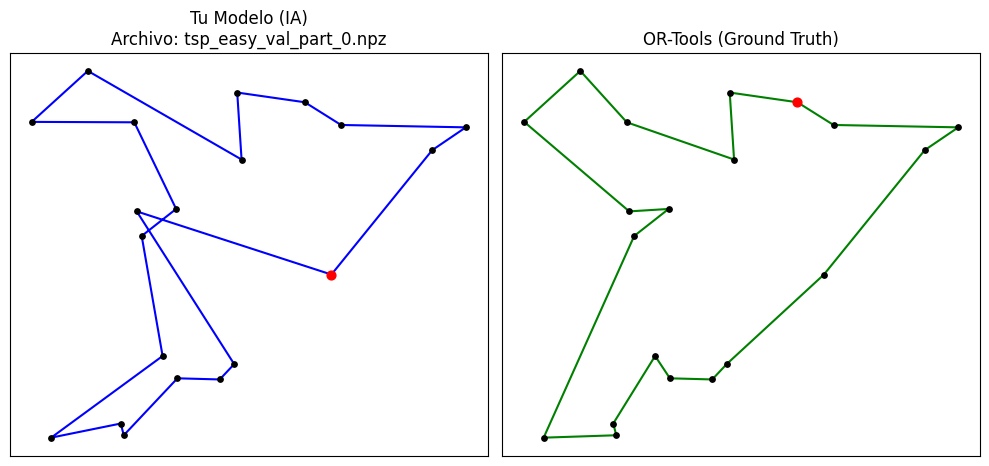

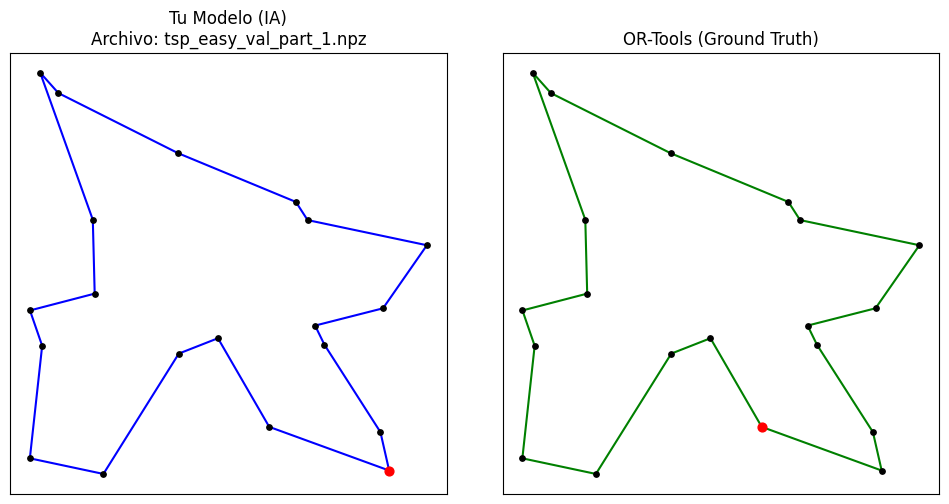

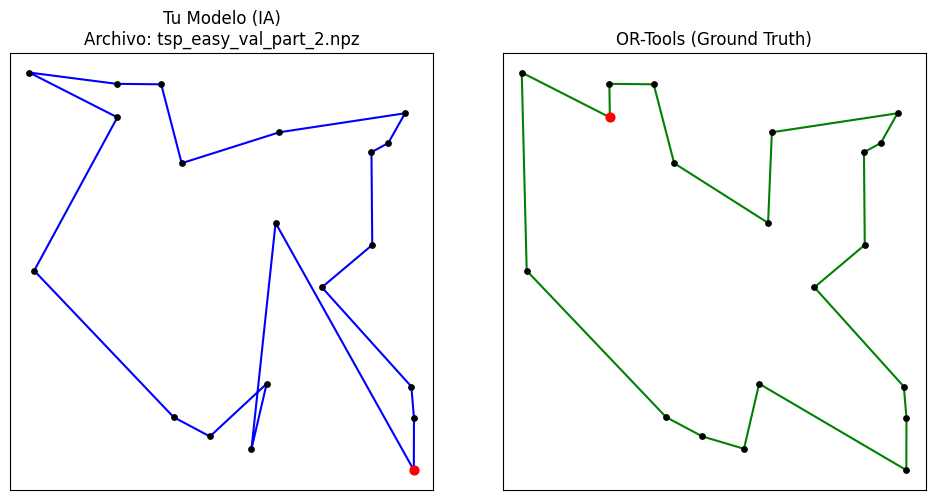

🛑 Deteniendo visualización para no saturar la pantalla (3 ejemplos mostrados).

🎨 GENERANDO VISUALIZACIONES PARA: MEDIUM
📸 Se encontraron 10 archivos. Generando 1 ejemplo de cada uno...


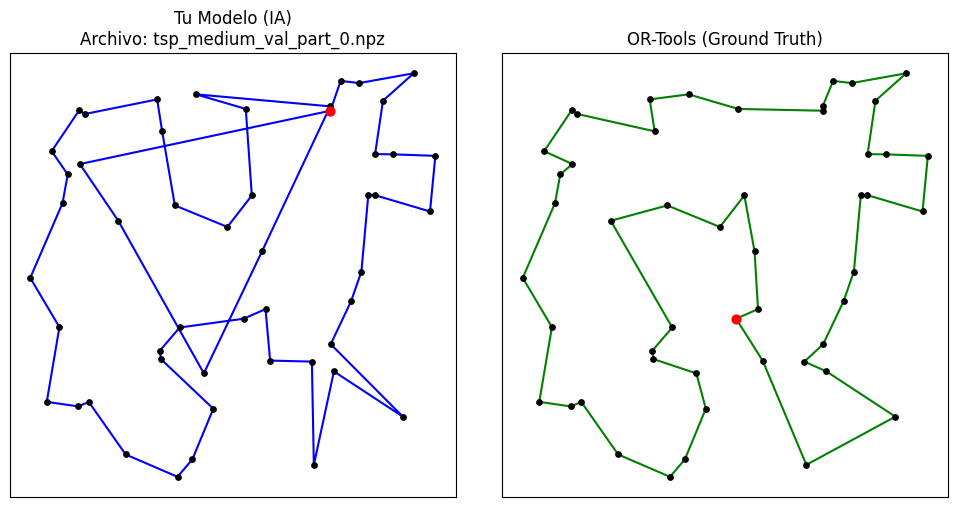

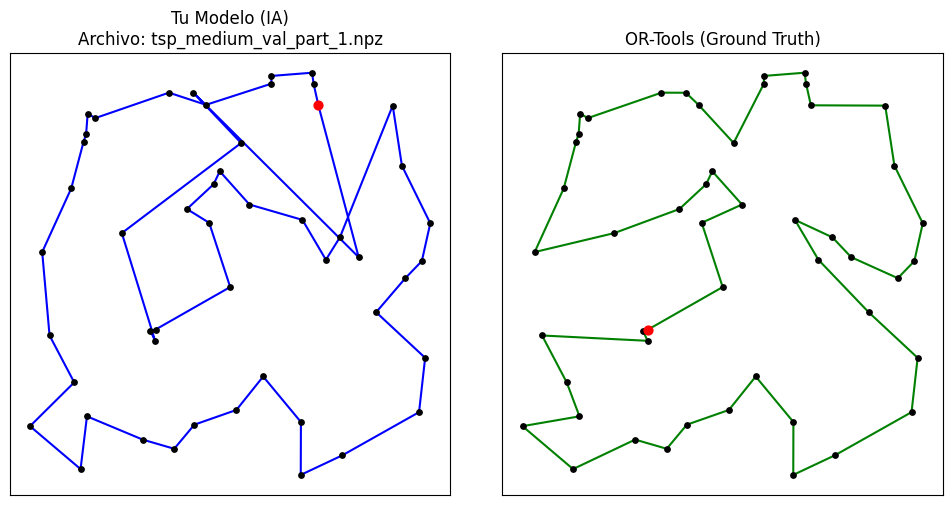

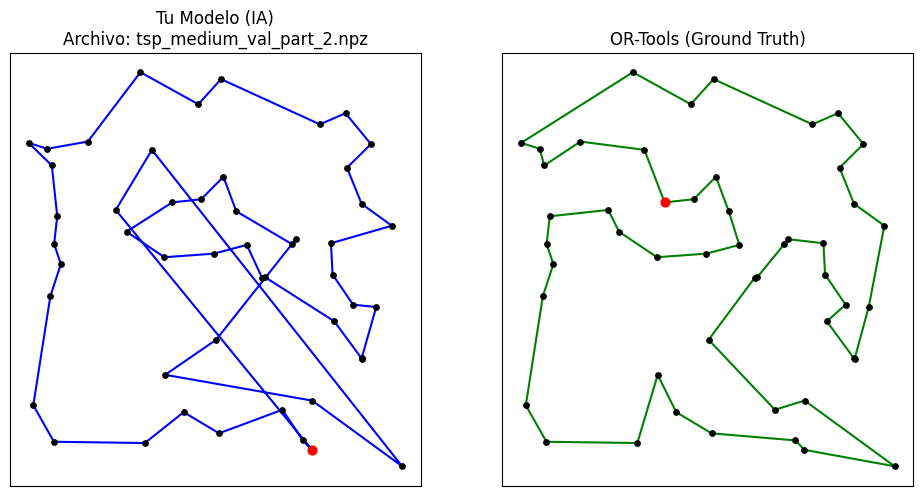

🛑 Deteniendo visualización para no saturar la pantalla (3 ejemplos mostrados).


In [15]:
# ==========================================
# 6. VISUALIZACIÓN COMPARATIVA (VISUALIZER)
# ==========================================


# --- CONFIGURACIÓN ---
# Usamos la misma configuración de rutas que antes
PATHS_CONFIG = {
    "EASY":   {"ckpt": "data_repo/EASY/checkpoint_EASY_best.pth",   "val_folder": "Data/Validation/Easy",   "val_prefix": "tsp_easy"},
    "MEDIUM": {"ckpt": "data_repo/MEDIUM/checkpoint_MEDIUM_best.pth", "val_folder": "Data/Validation/Medium", "val_prefix": "tsp_medium"},
    "HARD":   {"ckpt": "data_repo/HARD/checkpoint_HARD_best.pth",   "val_folder": "Data/Validation/Hard",   "val_prefix": "tsp_hard"}
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_route(ax, points, tour, title, color):
    """Dibuja una ruta en el subplot dado."""
    # points: array numpy [N, 2]
    # tour: array numpy [N] (indices)
    
    # Reordenamos los puntos según el tour
    route_points = points[tour]
    # Cerramos el ciclo (añadimos el primer punto al final)
    route_points = np.vstack([route_points, route_points[0]])
    
    # Dibujar líneas
    ax.plot(route_points[:, 0], route_points[:, 1], c=color, linewidth=1.5, linestyle='-')
    # Dibujar nodos
    ax.scatter(points[:, 0], points[:, 1], c='black', s=15, zorder=5)
    # Marcar inicio (rojo)
    ax.scatter(route_points[0, 0], route_points[0, 1], c='red', s=40, zorder=6, label='Inicio')
    
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

def visualize_comparison(phase_name, config):
    print(f"\n🎨 GENERANDO VISUALIZACIONES PARA: {phase_name}")
    
    if not os.path.exists(config["ckpt"]):
        print(f"⚠️ No hay modelo para {phase_name}, saltando...")
        return

    # 1. Cargar Modelo
    model = EncoderPointerModel(input_dim=2, d_model=128, nhead=8, enc_layers=3, dec_layers=2, max_seq_len=150).to(DEVICE)
    try:
        model.load_state_dict(torch.load(config["ckpt"], map_location=DEVICE, weights_only=False))
        model.eval()
    except Exception as e:
        print(f"❌ Error cargando modelo: {e}")
        return

    # 2. Buscar archivos parciales
    search_pattern = os.path.join(config["val_folder"], f"{config['val_prefix']}*.npz")
    files = sorted(glob.glob(search_pattern))
    
    if not files:
        print("❌ No encontré archivos de validación.")
        return

    # 3. Iterar sobre cada archivo encontrado
    print(f"📸 Se encontraron {len(files)} archivos. Generando 1 ejemplo de cada uno...")

    for i, f_path in enumerate(files):
        try:
            # Cargar archivo
            data = np.load(f_path, allow_pickle=True)
            points_all = data['points']
            sols_all = data['solutions']
            
            # --- SELECCIONAR UN EJEMPLO ALEATORIO O EL PRIMERO ---
            idx = 0 # Tomamos el primero de cada archivo (puedes cambiar a np.random.randint)
            
            sample_points = points_all[idx] # [N, 2]
            
            # Fix conversión object -> int64 para la solución real
            raw_sol = sols_all[idx]
            if isinstance(raw_sol, list) or raw_sol.dtype == np.object_:
                 sample_sol_true = np.array(raw_sol).astype(np.int64)
            else:
                 sample_sol_true = raw_sol.astype(np.int64)

            # Normalizar puntos para el modelo (0-1)
            max_val = sample_points.max()
            input_points = torch.tensor(sample_points / max_val, dtype=torch.float32).unsqueeze(0).to(DEVICE)

            # --- INFERENCIA DEL MODELO ---
            with torch.no_grad():
                logits = model(input_points, teacher_forcing=False)
                sample_sol_pred = logits.argmax(dim=2).squeeze(0).cpu().numpy()

            # --- DIBUJAR ---
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            
            # Gráfica Izquierda: Tu IA
            plot_route(axs[0], sample_points, sample_sol_pred, f"Tu Modelo (IA)\nArchivo: {os.path.basename(f_path)}", 'blue')
            
            # Gráfica Derecha: OR-Tools (El Maestro)
            plot_route(axs[1], sample_points, sample_sol_true, "OR-Tools (Ground Truth)", 'green')
            
            plt.tight_layout()
            plt.show()
            
            # Limite de seguridad: Si hay 50 archivos, no queremos 50 popups.
            # Comenta estas dos líneas si quieres verlos TODOS.
            if i >= 2: 
                print("🛑 Deteniendo visualización para no saturar la pantalla (3 ejemplos mostrados).")
                break

        except Exception as e:
            print(f"⚠️ Error visualizando {os.path.basename(f_path)}: {e}")
            continue

# --- EJECUTAR ---
visualize_comparison("EASY", PATHS_CONFIG["EASY"])
visualize_comparison("MEDIUM", PATHS_CONFIG["MEDIUM"])